In [2]:
import json
import os
import sys  
sys.path.insert(0, '..')
import models
import config
import numpy as np

from tensorflow.keras import layers, models as mdl
from yolo import Yolo
from layers import conv_block


In [7]:
weight_path = os.path.join('..', 'assets', 'model-mobilenet-yolo-fpn.320-1830.87.h5')
val_notation = os.path.join('..', 'assets', 'validation.txt')
train_notation = os.path.join('..', 'assets', 'training.txt')
class_name = os.path.join('..', 'assets', 'class_name.txt')
image_path = os.path.join('/home', 'hadioz', 'Documents', 'skripsi', 'dataset', 'WIDER_val', 'images')

predict_path = os.path.join('..', 'assets', 'predict')
gt_path = os.path.join('..', 'assets', 'ground_truth')
output_ap = os.path.join('..', 'assets', 'result')
temp_json = os.path.join('..', 'assets', 'temp_json') 

In [4]:
with open(val_notation) as json_file:
  datajson = json.load(json_file)

In [8]:
model = Yolo(class_name, config.cfg, weight_path)

(None, 52, 52, 256)
(None, 26, 26, 512)
(None, 13, 13, 1024)
load from ../assets/model-mobilenet-yolo-fpn.320-1830.87.h5
(None, 52, 52, 18)
(None, 26, 26, 18)
(None, 13, 13, 18)
3
3
3


In [19]:
model.export_gt(datajson[:1000],image_path, gt_path)

In [20]:
model.export_predict(datajson[:1000], image_path, predict_path)

100%|██████████| 500/500 [13:05<00:00,  1.57s/it]


['face'] {'face': 21155}
fp  16158
tp  100
recall  100
prec  100
0.01% = face AP 


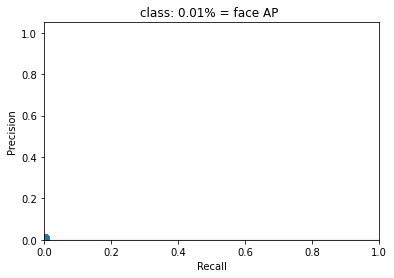

mAP = 0.01%
[('face', 21155)]


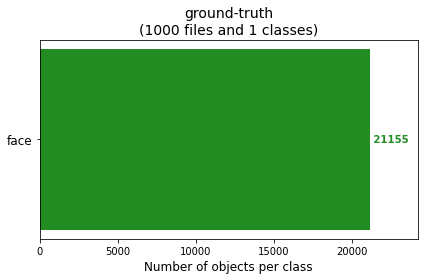

[('face', 16258)]


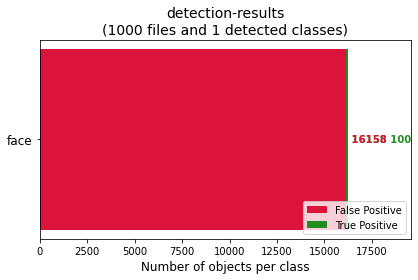

[('face', 5.181631338592769e-05)]


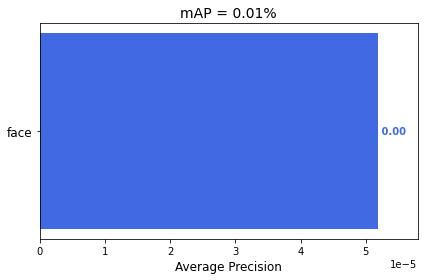

In [21]:
model.eval_map(gt_path, predict_path, temp_json, output_ap)

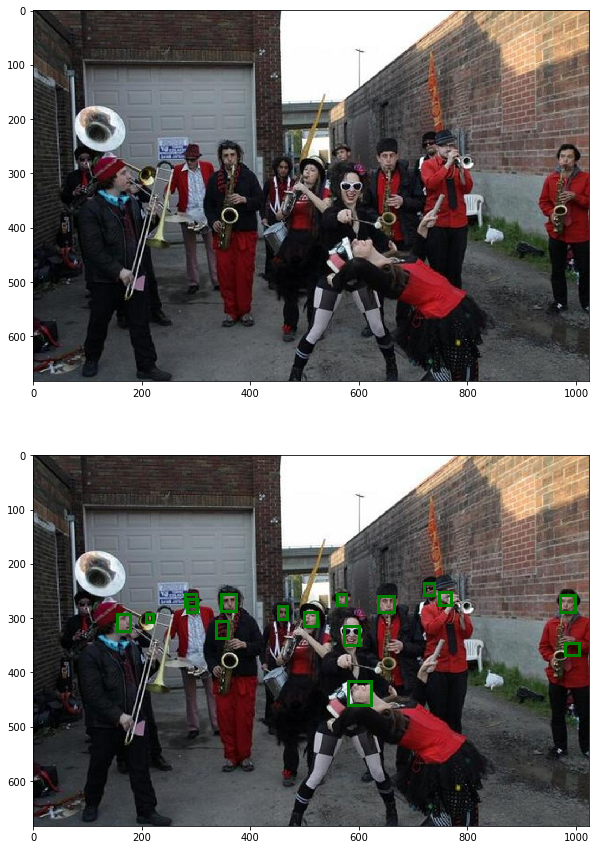

In [16]:
test_image = os.path.join(image_path, datajson[8]['name'])
model.predict(test_image)

In [7]:
model.build_litemodel('../assets/model1.tflite')

2021-12-23 15:05:07.244017: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpsl8fnpr7/assets


2021-12-23 15:05:25.825775: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-12-23 15:05:25.825924: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-23 15:05:25.852706: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.027ms.
  function_optimizer: function_optimizer did nothing. time = 0.003ms.

2021-12-23 15:05:29.603803: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-12-23 15:05:29.603871: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-12-23 15:05:29.911296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


In [6]:
with open(val_notation) as json_file:
    datajson = json.load(json_file)

In [18]:
def FPN_lite(backbone_model, classes=1):
    large, medium, small = backbone_model.outputs

    route_input = small
    print(route_input.shape)
    x = conv_block(inputs=small, filters=256, kernel=(
        1, 1), strides=(1, 1), block_id=1)
    x = layers.UpSampling2D()(x)

    route1 = conv_block(inputs=medium, filters=256,
                        kernel=(1, 1), strides=(1, 1), block_id=2)
    x = layers.Concatenate()([route1, x])

    x = conv_block(inputs=x, filters=256, kernel=(
        1, 1), strides=(1, 1), block_id=3)
    x = conv_block(inputs=x, filters=512, kernel=(
        3, 3), strides=(1, 1), block_id=4)
    x = conv_block(inputs=x, filters=256, kernel=(
        1, 1), strides=(1, 1), block_id=5)
    x = conv_block(inputs=x, filters=512, kernel=(
        3, 3), strides=(1, 1), block_id=6)
    x = conv_block(inputs=x, filters=256, kernel=(
        1, 1), strides=(1, 1), block_id=7)

    route1 = x

    x = conv_block(inputs=x, filters=512, kernel=(
        3, 3), strides=(1, 1), block_id=21)
    conv_mbbox = layers.Conv2D(
        3 * (classes + 5), 1, strides=1, padding='same', use_bias=True)(x)
    
    print(conv_mbbox.shape)

    route1 = layers.ZeroPadding2D(((1, 0), (1, 0)))(route1)
    x = layers.Conv2D(512, 3, strides=2, padding='valid',
                      use_bias=True)(route1)
    x = layers.Concatenate()([x, route_input])

    x = conv_block(inputs=x, filters=512, kernel=(
        1, 1), strides=(1, 1), block_id=22)
    x = conv_block(inputs=x, filters=1024, kernel=(
        3, 3), strides=(1, 1), block_id=23)
    x = conv_block(inputs=x, filters=512, kernel=(
        1, 1), strides=(1, 1), block_id=24)
    x = conv_block(inputs=x, filters=1024, kernel=(
        3, 3), strides=(1, 1), block_id=25)
    x = conv_block(inputs=x, filters=512, kernel=(
        1, 1), strides=(1, 1), block_id=26)

    x = conv_block(inputs=x, filters=1024, kernel=(
        3, 3), strides=(1, 1), block_id=27)
    conv_lbbox = layers.Conv2D(
        3 * (classes + 5), 1, strides=1, padding='same', use_bias=True)(x)
    print(conv_lbbox.shape)

    return [conv_mbbox, conv_lbbox]

In [20]:
mnetinputsone = layers.Input((416, 416, 3))

mobilenet = models.MobileNet(mnetinputsone)
outputs = FPN_lite(mobilenet,1)
mdl_fpn = mdl.Model(mnetinputsone, outputs)
mdl_fpn.summary()

mdl_fpn.save_weights('../assets/weight.h5')


(None, 52, 52, 256)
(None, 26, 26, 512)
(None, 13, 13, 1024)
(None, 13, 13, 1024)
(None, 26, 26, 18)
(None, 13, 13, 18)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_block_0 (Conv2D)           (None, 208, 208, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
conv_block_0_bn (BatchNormaliza (None, 208, 208, 32) 128         conv_block_0[0][0]               
__________________________________________________________________________________________________
conv_block_0_relu (ReLU)        (None, 208, 208, 32) 0           conv_b

In [9]:
def yolo_header(backbone, num_class=1, anchor_size=3):
  large, medium, small = backbone.outputs
  large = layers.Conv2D(anchor_size * (num_class + 5), kernel_size=1, strides=1, padding='same',use_bias=False)(large)
  medium = layers.Conv2D(anchor_size * (num_class + 5), kernel_size=1, strides=1, padding='same',use_bias=False)(medium)
  small = layers.Conv2D(anchor_size * (num_class + 5), kernel_size=1, strides=1, padding='same',use_bias=False)(small)
  return [large, medium, small]

In [10]:
inputs = layers.Input((612, 612, 3))

mobilenetv2 = models.MobileNetV2(inputs)
outputs = yolo_header(mobilenetv2, 1, 3)
for out in outputs:
  print(out.shape)
  
model_origin = mdl.Model(inputs, outputs, name='MobilenetV2 Yolo')

model_origin.summary()


(None, 73, 73, 18)
(None, 30, 30, 18)
(None, 12, 12, 18)
Model: "MobilenetV2 Yolo"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 612, 612, 3) 0                                            
__________________________________________________________________________________________________
conv_block_0 (Conv2D)           (None, 306, 306, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
conv_block_0_bn (BatchNormaliza (None, 306, 306, 32) 128         conv_block_0[0][0]               
__________________________________________________________________________________________________
conv_block_0_relu (ReLU)        (None, 306, 306, 32) 0           conv_block_0_bn[0][0]            
__________________________

In [11]:
arr = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
arr = arr.reshape((5,2))
print(arr.shape[0] != arr.shape[1])


inp = layers.Input((25, 25, 3))
print(inp.shape[1] == inp.shape[2])


for i in range(0, 4, 4):
  print(i)

True
True
0


In [22]:
if 1e-4 > 1e-3:
  print("true")